# Searching for Best-Performing Feature/Model/Dataset Combinations
Screening the efficacy of model, feature, and dataset combinations, with crossvalidation.
***
***
The package supports any feature type in deepchem (https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html). The package includes a number of model types already, but natively supports any model class from [deepchem](https://deepchem.io/) or [sklearn](https://scikit-learn.org/stable/). These are all accesed through  the `ToxModel` class. 

NOTE: Some of these calculations can be lengthy due to dataset size, feature computation, and model training times. We recommend running this type of screening in parallel on a computing cluster in order to speed up calculation time. See the model_screening folder for py files that were run in parallel on a computing cluster in order to speed up computation times. 

In [1]:
import cytoxnet.models.evaluate
import cytoxnet.dataprep
import pandas as pd

A targets codex or target/datafile pairs is required in order to specify the correct target for each dataset in the crossvalidated evaluation function, which can screen multiple datasets, features, and models and their combinations. The full targets codex for all the data included in the package is:

In [2]:
package_data_targets_codex = {
    'lunghini_fish_LC50': 'fish_LC50',
    'lunghini_daphnia_EC50': 'daphnia_EC50',
    'lunghini_algea_EC50': 'algea_EC50',
    'zhu_rat_LD50': 'rat_LD50',
    'chembl_ecoli_MIC': 'ecoli_MIC'
}


For this example, we define a targets codex with a subset of the data in order to reduce computation time:

In [3]:
example_targets_codex = {
    'lunghini_fish_LC50': 'fish_LC50',
    'lunghini_algea_EC50': 'algea_EC50'
}

We also define the datafiles that we would like to use for screening. 

In [4]:
datafiles = [
    'lunghini_fish_LC50',
    'lunghini_algea_EC50',
]


We define the machine learning models that we would like to test. In this case, we define two regression ML models to test: GPR and LASSO:

In [5]:
ml_models = ['GPR', 'LASSO']

We also need to choose the feature type(s) to test. Note that the available featurizers are from DeepChem and some of the feature requirements (i.e. internet, modules, arguments) may vary. For more details on featurizer requirements, see https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html. 

In [6]:
featurizers = [
    'CircularFingerprint',
    'RDKitDescriptors'
]


To perform a crossvalidated evaluation of all model, feature, and dataset combinations by computing the r2 score and mean squared error for all combinations, we pass our information to the grid_evaluate_crossval function. Note that the cell below may take a few minutes to run, mainly due to featurization cost. 

In [7]:
df = cytoxnet.models.evaluate.grid_evaluate_crossval(
    datafiles,
    ml_models,
    featurizers,
    example_targets_codex,
    parallel=True,
    transformations=['NormalizationTransformer']
)



We see that the output dataframe contains the r2 score and mean squared error for every model, feature, and data combination that was passed:

In [8]:
df

,datafile,model,featurizer,r2_score,mean_squared_error
0,lunghini_fish_LC50,GPR,CircularFingerprint,0.063744,6.768052
1,lunghini_fish_LC50,GPR,RDKitDescriptors,-0.001547,7.241770
2,lunghini_fish_LC50,LASSO,CircularFingerprint,-0.001481,7.255457
3,lunghini_fish_LC50,LASSO,RDKitDescriptors,0.429778,4.115878
4,lunghini_algea_EC50,GPR,CircularFingerprint,0.044131,5.237650
5,lunghini_algea_EC50,GPR,RDKitDescriptors,-0.001021,5.511164
6,lunghini_algea_EC50,LASSO,CircularFingerprint,-0.008762,5.531236
7,lunghini_algea_EC50,LASSO,RDKitDescriptors,0.314764,3.762626


 The to_csv function can be used to save the results to a csv file. 

In [9]:
df.to_csv('example_results_regression_grid_test.csv')

### Compounds Codex Functionality 

The grid_evaluate_crossval function may also be passed a compounds codex so that features do not have to be recomputed. To create the compounds codex:

In [10]:
cytoxnet.dataprep.io.create_compound_codex('./')

We can add molecules present in specified datasets and their corresponding features to the codex to eliminate the computational cost of recomputing features. 

In [11]:
cytoxnet.dataprep.io.add_datasets(
                 dataframes=datafiles,
                 names=['Lunghini_fish', 'Lunghini_algae'],
                 id_col='smiles',
                 db_path='./',
                 new_featurizers=featurizers)

{'Lunghini_fish':      chemical_formula                        smiles       casnum  \
 0              C8H7Br               C=C(Br)c1ccccc1      98-81-7   
 1               CHBr3                     BrC(Br)Br        75252   
 2             C2HBr2N                    N#CC(Br)Br    3252-43-5   
 3             C8H6Br4        BrC(Br)c1ccccc1C(Br)Br   13209-15-9   
 4         C10H10Br2O2        BrC(Br)c1ccccc1OCC1CO1   30171-80-3   
 ...               ...                           ...          ...   
 2194            C4H4S                       c1ccsc1     110-02-1   
 2195        C12H8N2OS  c1ccc(-c2noc(-c3cccs3)n2)cc1  330459-31-9   
 2196         C10H7N3S    c1ccc2[nH]c(-c3cscn3)nc2c1     148-79-8   
 2197           C7H5NS                 c1ccc2scnc2c1      95-16-9   
 2198           C2H3N3                    c1nc[nH]n1     288-88-0   
 
       molecular_weight species  fish_LC50      units  \
 0           183.045181    fish  -1.897120  log(mg/L)   
 1           252.730637    fish   3.157

We can then pass the compounds codex to the grid_evaluate_crossval function so that features are not recomputed. Note that the code may still take a few minutes to train and evaluate the machone learning models. 

In [12]:
df = cytoxnet.models.evaluate.grid_evaluate_crossval(
    datafiles,
    ml_models,
    featurizers,
    example_targets_codex,
    codex='./compounds.csv',
    transformations=['NormalizationTransformer']
)

### Evaluating Classification Models

We can also use the same function to evaluate classification models, but first we need to define the classification models we would like to test. Here we define two: GPC and KNNC.

In [13]:
ml_models_classification = ['GPC', 'KNNC']

In [14]:
df_class = cytoxnet.models.evaluate.grid_evaluate_crossval(
    datafiles,
    ml_models_classification,
    featurizers,
    example_targets_codex,
    parallel=False,
    codex='./compounds.csv',
    binary_percentile=0.5,
    use_weights=False
)


In [17]:
df_class

,datafile,model,featurizer,recall_score,jaccard_score
0,lunghini_fish_LC50,GPC,CircularFingerprint,0.595693,0.482332
1,lunghini_fish_LC50,GPC,RDKitDescriptors,0.008132,0.008120
2,lunghini_fish_LC50,KNNC,CircularFingerprint,0.609755,0.489354
3,lunghini_fish_LC50,KNNC,RDKitDescriptors,0.751198,0.592581
4,lunghini_algea_EC50,GPC,CircularFingerprint,0.608369,0.466353
5,lunghini_algea_EC50,GPC,RDKitDescriptors,0.008052,0.008052
6,lunghini_algea_EC50,KNNC,CircularFingerprint,0.611280,0.472354
7,lunghini_algea_EC50,KNNC,RDKitDescriptors,0.729720,0.575400


### Simple Visualization 

We can create a quick plot of the results of the grid search for each dataset and metric as follows:

In [15]:
import seaborn as sns

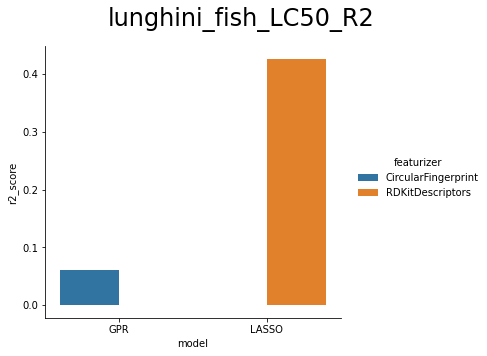

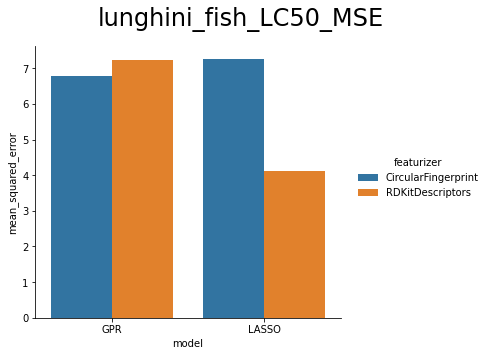

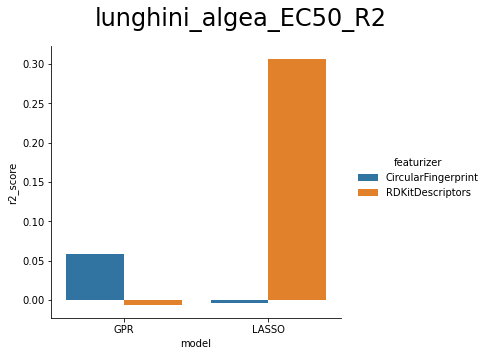

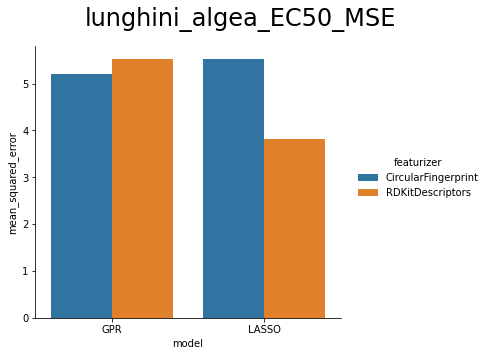

In [16]:
for data in datafiles:
    results = df.loc[df['datafile']==data]
    ax = sns.catplot(x='model', y='r2_score', hue='featurizer', data=results, kind='bar')
    ax.fig.suptitle((data + "_R2"),
                    fontsize=24)
    ax.tight_layout()

    ay = sns.catplot(x='model', y='mean_squared_error', hue='featurizer', data=results, kind='bar')
    ay.fig.suptitle((data + "_MSE"),
                    fontsize=24)
    ay.tight_layout()